In [1]:
from utils import *

Main Goal: Identify binaries with dark companions in Gaia data and estimate the mass and period of a dark companion (BH or NS) with RUWE (similar to chi square) and Radial Velocity error are available.

These past weeks I have: 

1) Simulated binary star systems using astromet sampling the parameters from specific distributions
2) Calculated inferred Periods and Mass ratios using these sampled physical and viewer specific parameters
3) Sampled various parameter spaces in various physical, viewing parameters and calculated errors to analyze the distributions of binaries with CO and MS, look at places where the density of CO is similar or greater to the density of MS
4) Used Machine Learning to fill in missing rows from gaia data such as mass ratio

Notes:

Shahaf et al. (2019) presented the astrometric mass ratio function (AMRF) dependent on mass ratio and luminosity ratio between the two components
Once this AMRF is calculated binaries with DC have a high probability of being found in regions above AMRF for triples in a AMRF vs primary mass paramter space

Next Steps:

- Use SEVN to calculate properties of a binary system after some time, then use astromet on these stars to simulate a GAIA observation, compare to real data

- Sample the mass of primary from a distribution of:
    Absolute Magnitude in the G band 
    Blue Photometric (Bp) minus Red Photometric (Rp) Color Index
    Mass of primary

Given the first two predict the third from the parameter space

# Signatures of dark companions in Gaia data. 

Using the formalism in Andrew et al, the mass of a dark companion (BH or NS) can be estimated if both RUWE and Radial Velocity error are available. 

Using population synthesis and the astromet software generate mock Gaia data and predict the distribution of companion masses (or mass ratios) for sources in Gaia DR3.

Identify binary systems that posses signatures of dark companions in Gaia data using RUWE for the selection and infer the mass and period of the dark companion using a combination of orbital parameters and errors. 

RUWE - re-normalized quare root of the reduced chi-square

Use RUWE to select the star systems to analyze. Look for high RUWE

High RUWE are dominated by sources with unmodelled extra contributions of noise, most ubiquitously caused by binary (and higher multiple) systems

(RUWE is expected to be around 1.0 for sources where the single-star model provides a good fit to the astrometric observations. A value significantly greater than 1.0 (say, >1.4) could indicate that the source is non-single or otherwise problematic for the astrometric solution.)

Possible projects explorations 

- Identify semi resolved systems from gaia to look for systems with star clusters near a black hole and identify them
- Use ML to classify objects in the Gaia DR3 catalogue: apply labels such as “galaxy nucleus”, “binary star”, “star-forming region”

In [70]:
# read the CSV file back into a DataFrame
df_sim = pd.read_csv('data/100k.csv')

# print the column names
print(df_sim.columns)

Index(['RA', 'Dec', 'pmRA', 'pmDec', 'pllx', 'M_tot', 'q', 'l', 'a', 'e', 'P',
       'tPeri', 'vTheta', 'vPhi', 'vOmega', 'predict_dTheta', 'simple_dTheta',
       'N_obs', 'sigma_al', 'sigma_ac', 'fit_ra', 'fit_dec', 'fit_pmrac',
       'fit_pmdec', 'fit_pllx', 'sigma_rac', 'sigma_dec', 'sigma_pmrac',
       'sigma_pmdec', 'sigma_pllx', 'N_vis', 'frac_good', 'AEN', 'UWE'],
      dtype='object')


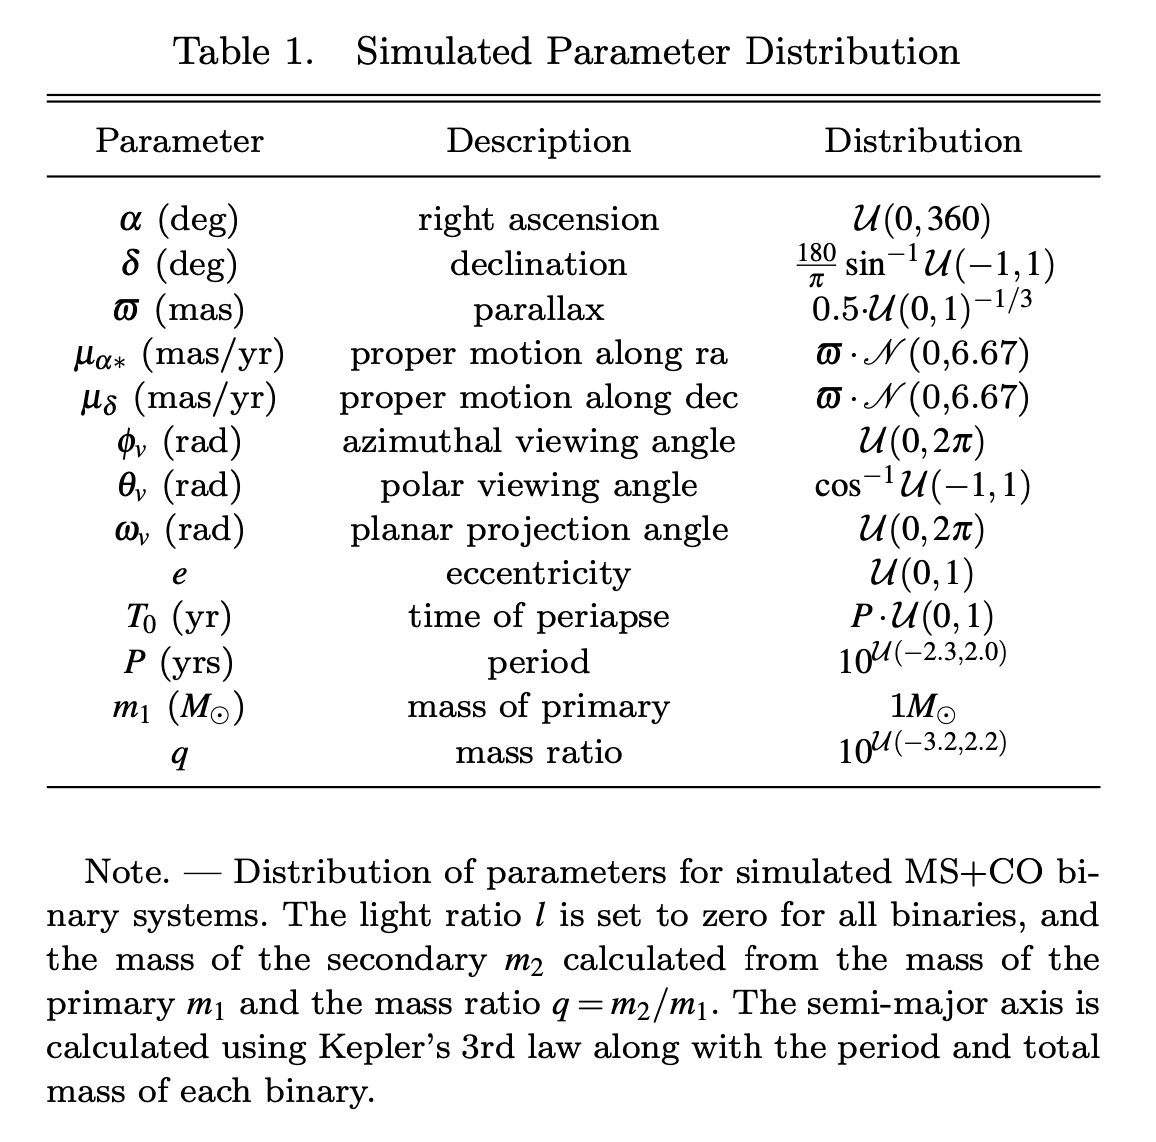

In [71]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/sim_param_distr.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

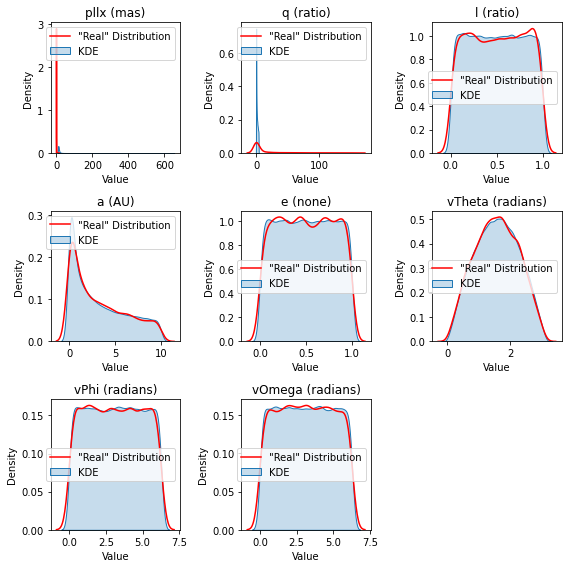

In [72]:
# Example usage
columns_to_plot = ['pllx', 'q', 'l', 'a', 'e', 'vTheta', 'vPhi', 'vOmega']
units = {
    'pllx': ' (mas)',
    'q': ' (ratio)',
    'l': ' (ratio)',
    'a': ' (AU)',
    'e': ' (none)',
    'vTheta': ' (radians)',
    'vPhi': ' (radians)',
    'vOmega': ' (radians)'
}

plot_distributions(df_sim, columns_to_plot, units)

In [73]:
# Keep in the dataframe only Periods less than dr3Period = 2.8333333333333335 years
df_sim = df_sim[df_sim['P'] <= dr3Period]

### Calculate $\zeta_0$ (P = B)

##### this result agrees well for all P < B but deviates at longer periods - Andrew et al

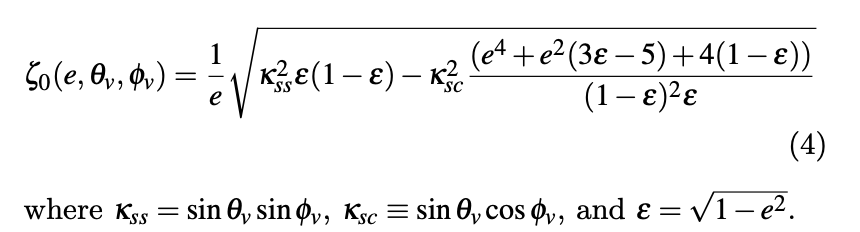

In [74]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/zeta_0.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed


In [75]:
# test the function on df['e'], df['vTheta'], df['vPhi']
df_sim['zeta_0'], indeces = zeta_0(df_sim['e'], df_sim['vTheta'], df_sim['vPhi'])

# use indeces to get the rows of the df
df_sim.loc[indeces]

# remove all these rows from the DataFrame
df_sim = df_sim.drop(indeces)

# remove all the zeta_0 values > 1
df_sim = df_sim[df_sim['zeta_0'] <= 1]

/Users/ynwa1995/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


### $\beta_0$

### Calculate $\beta_0$ (P = B)

##### this result agrees well for all P < B but deviates at longer periods - Andrew et al

In [76]:
# calculate beta_0 for all the data points in the dataframe
df_sim['beta_0'] = beta_0(df_sim['e'], df_sim['vTheta'], df_sim['vPhi'])

# Plot $\Theta_{\nu}$ vs $\Phi_{\nu}$

##### for $ecc = [0.01 \text{ to } 0.99]$ 
##### *color-mapped by* *$\zeta_0$*, *$\beta_0$*, *$\frac{\zeta_0}{\beta_0}$*, *$\frac{\zeta_0^2}{\beta_0}$*

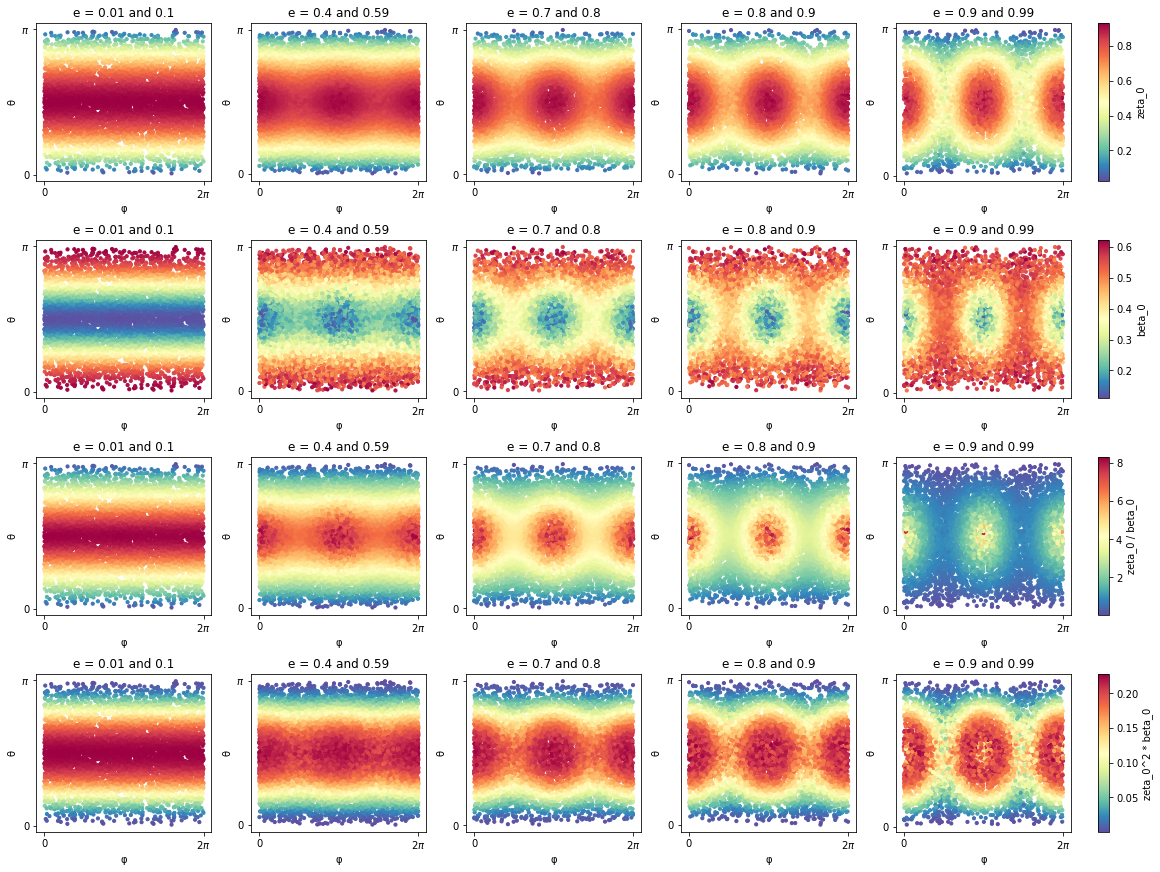

In [77]:
eccentricity_ranges = [
    (0.01, 0.1),
    (0.4, 0.59),
    (0.7, 0.8),
    (0.8, 0.9),
    (0.9, 0.99)
]

color_codes = [
    ('zeta_0', 'zeta_0', lambda df_sim: df_sim['zeta_0']),
    ('beta_0', 'beta_0', lambda df_sim: df_sim['beta_0']),
    ('zeta_0/beta_0', 'zeta_0 / beta_0', lambda df_sim: df_sim['zeta_0'] / df_sim['beta_0']),
    ('zeta_0**2 * beta_0', 'zeta_0^2 * beta_0', lambda df_sim: (df_sim['zeta_0']**2) * df_sim['beta_0'])
]

# Assuming df is your DataFrame
plot_eccentricity_distributions(df_sim, eccentricity_ranges, color_codes)

# Calculate Radial Velocity Error
        
#### Assume P<=B and zeta = zeta_0

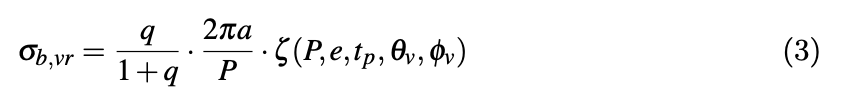

In [78]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/spectr_error.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed


### Units: 
- q (none)
- a (AU)
- P (yrs)
- $\zeta_0$ (none)

$\sigma_{(b),(vr)}$ $\left(\frac{\text{AU}}{\text{yrs}}\right)$

In [79]:
df_sim['sigma_spectroscopic_error'] = sigma_spectroscopic_error(df_sim['q'], df_sim['a'], df_sim['P'], df_sim['zeta_0'])

# Calculate sigma_theta

#### Assume P<=B and beta = beta_0

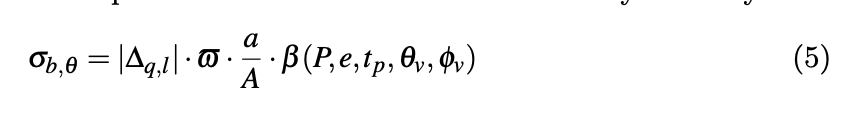

In [80]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/astr_error.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

### Units: 
- q (none)
- l (none)
- parallax (mas)
- a (AU)
- A ($AU^{-1}$)
- beta (none)

$\sigma_{(b),(\theta)}$ ($\text{mas}$)

In [81]:
df_sim['sigma_astrometric_error'] = sigma_astrometric_error(df_sim['q'], df_sim['l'], df_sim['pllx'], df_sim['a'], AU, df_sim['beta_0'])

# Calculate inferred P and q 

#### The inferred mass ratios and periods using Equations 8 and 11 are described below

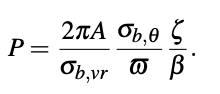

In [82]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/inferred_P.png'
display(Image(filename=img_path, width=200, height=100))  # Adjust width and height as needed

### Units: 
- A (AU)
- $\sigma_{(b),(\theta)}$ ($\text{mas}$)
- $\sigma_{(b),(vr)}$ $(\text{AU}^{-1}\text{yrs})$
- parallax ($mas^{-1}$)
- zeta 
- beta

P (yrs)


In [83]:
df_sim['inferred_P'] = inferred_P(AU, df_sim['sigma_spectroscopic_error'], df_sim['sigma_astrometric_error'], df_sim['pllx'], df_sim['zeta_0'], df_sim['beta_0'])


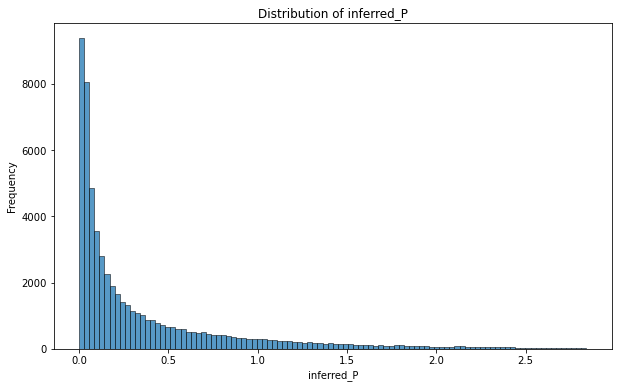

In [84]:
# make a dataframe with df['inferred_P'] < 2.84 
df_sim = df_sim[df_sim['inferred_P'] < 2.84]

# plot df_filter distribution of ['inferred_P']
plt.figure(figsize=(10, 6))
sns.histplot(df_sim['inferred_P'], bins=100)
plt.xlabel('inferred_P')
plt.ylabel('Frequency')
plt.title('Distribution of inferred_P')
plt.show()


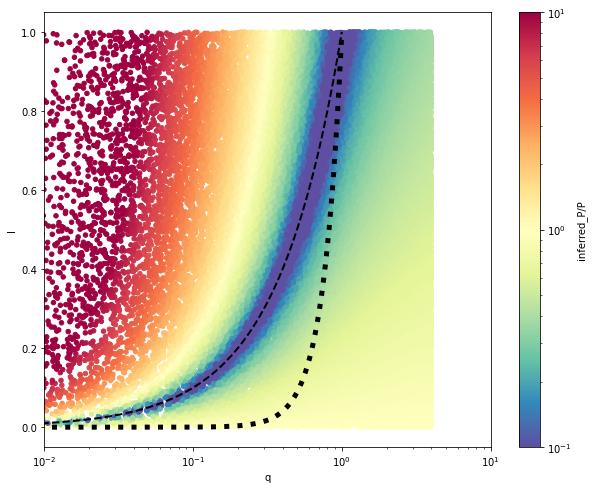

In [85]:
plot_scatter_with_lines(df_sim, 'q', 'l', 'inferred_P', 'P', 'inferred_P/P')

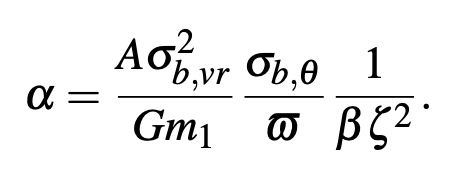

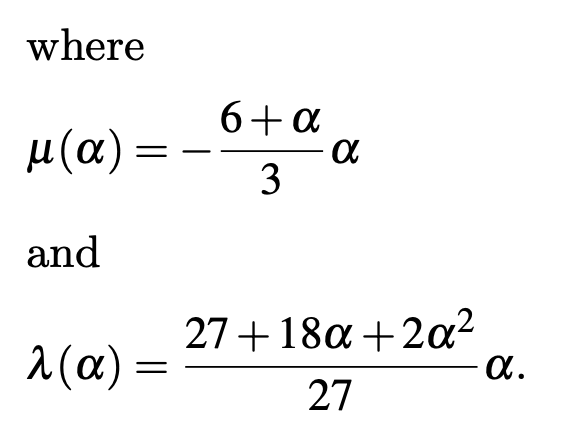

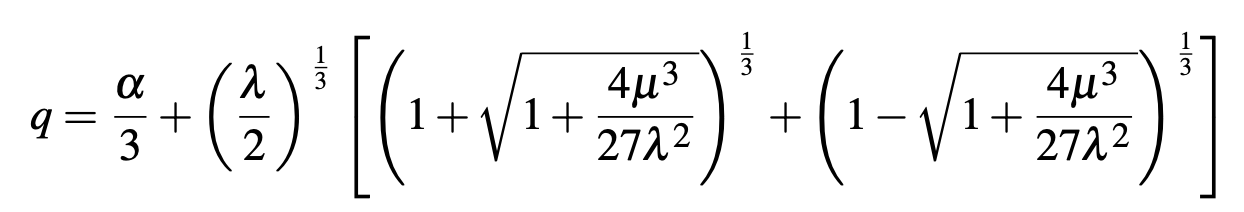

In [86]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/solve_q_1.png'
display(Image(filename=img_path, width=150, height=100))  # Adjust width and height as needed

# Display an image from a local file with specified size
img_path = 'images/solve_q_2.png'
display(Image(filename=img_path, width=150, height=100))  # Adjust width and height as needed

# Display an image from a local file with specified size
img_path = 'images/inferred_q.png'
display(Image(filename=img_path, width=400, height=300))  # Adjust width and height as needed

### Alpha Units: 
- A - (AU)
- $\sigma_{(b),(\theta)}$ ($\text{mas}$)
- $\sigma_{(b),(vr)}$ $\left(\text{AU}^{2}{\text{yrs}^{-2}}\right)$
- G - ($\text{AU}^{-3} \cdot M_{Sun}^{1} \cdot \text{yrs}^{2}$)
- M_1 - $M_{Sun}^{-1}$
- parallax ($\text{mas}^{-1}$)
- zeta
- beta

alpha (none)


In [88]:
df_sim['inferred_q'] = solve_q(AU, G, M_sun, df_sim['sigma_spectroscopic_error'], df_sim['sigma_astrometric_error'], df_sim['pllx'], df_sim['zeta_0'], df_sim['beta_0'])


<ipython-input-88-a2418d3dda20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim['inferred_q'] = solve_q(AU, G, M_sun, df_sim['sigma_spectroscopic_error'], df_sim['sigma_astrometric_error'], df_sim['pllx'], df_sim['zeta_0'], df_sim['beta_0'])


In [89]:
df_sim_filtered = df_sim[df_sim['inferred_q']<1]

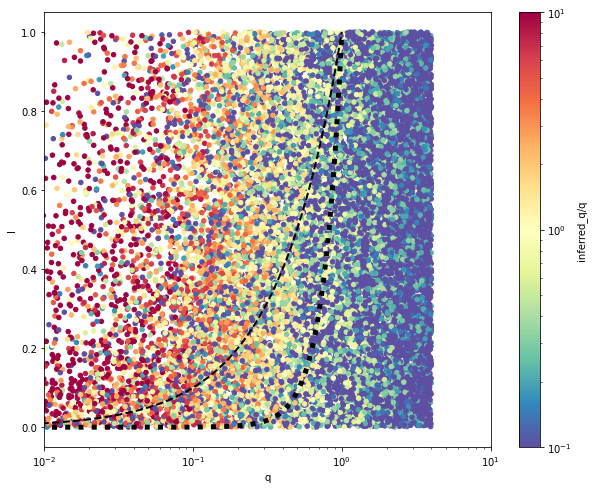

In [90]:
plot_scatter_with_lines(df_sim_filtered, 'q', 'l', 'inferred_q', 'q', 'inferred_q/q')

# Gaia DR3 

In [91]:
# load data in a dataframe
gaia = pd.read_csv('data/gaia_dr3.csv')

In [92]:
# load data in a dataframe
nss_two_body_orbit = pd.read_csv('data/nss_two_body_orbit.csv')

In [93]:
nss_two_body_orbit.describe()

dec         period  arg_periastron     SOURCE_ID  \
count  169227.000000  443205.000000   273030.000000  4.432050e+05   
mean       -3.410782     371.842253      125.530307  3.791747e+18   
std        46.689708     392.293748      120.531281  1.977719e+18   
min       -89.875663       0.200537        0.000000  3.371120e+13   
25%       -45.864659       4.414740        0.000000  2.018199e+18   
50%        -5.746427     258.220704       99.362452  4.205616e+18   
75%        38.531800     650.187907      233.018793  5.600709e+18   
max        89.686668    9935.832615      359.999983  6.917528e+18   

               pmdec  center_of_mass_velocity   t_periastron  mass_ratio  \
count  169227.000000            220527.000000  443205.000000  155.000000   
mean       -6.522915                -2.154106      -0.834767    0.376401   
std        28.583077                43.138190     154.612285    0.310205   
min     -1230.644057              -468.173633    -827.840146    0.021183   
25%       -12.106472               -25.415627     -35.025899    0.176682   
50%        -3.652064                -2.918660       0.001400    0.321730   
75%         2.926059                20.546086      35.317285    0.472020   
max      1251.943630               593.617572     955.611883    2.184466   

       g_luminosity_ratio             ra  semi_amplitude_primary  \
count        87073.000000  169227.000000           187060.000000   
mean             0.317770     192.935934               17.760297   
std              0.250262     102.247882               17.641089   
min              0.000002       0.001616                0.268854   
25%              0.111583     107.367212                6.636013   
50%              0.250546     197.068266               11.794754   
75%              0.462671     285.587600               22.403749   
max              0.999951     359.998814              352.154895   

        inclination           pmra   eccentricity  
count  87073.000000  169227.000000  442257.000000  
mean      78.788017      -1.499210       0.222938  
std        8.871614      30.054025       0.200021  
min       33.976537    -826.005927       0.000000  
25%       74.085812      -9.171420       0.039020  
50%       80.291790      -1.590336       0.187216  
75%       85.327962       5.821184       0.356045  
max      117.152293    1917.369508       0.979809

### Cross match sample with nss_two_body_orbit dataset containing orbital parameters 

In [94]:
# merge gaia to nss_two_body_orbit on source_id. I want to keep all columns but the rows need to have the same source_id
nss_gaia = pd.merge(nss_two_body_orbit, gaia, on='SOURCE_ID', how='inner')

df = nss_gaia

### Calculate Absolute Magnitude from Apparant Magnitude

In [97]:
# load data in a dataframe
cross_df = pd.read_csv('data/gaia_dr3_cross.csv')

In [99]:
cross_df.columns

Index(['SOURCE_ID', 'ra', 'dec', 'phot_g_mean_mag', 'bp_rp', 'parallax',
       'pmra', 'pmdec', 'ruwe', 'radial_velocity_error', 'rv_method_used',
       'rv_nb_transits', 'ag_gspphot', 'ebpminrp_gspphot', 'non_single_star',
       'radial_velocity', 'parallax_error', 'mass_ratio',
       'g_luminosity_ratio'],
      dtype='object')

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate distance from parallax
def calculate_distance(parallax):
    """Convert parallax in milliarcseconds to distance in parsecs."""
    # Ensure non-negative parallax
    with np.errstate(divide='ignore'):
        distance = 1000 / parallax
    # Handle zero and negative parallax by setting distance to NaN
    distance[parallax <= 0] = np.nan
    return distance

# Function to calculate absolute magnitude
def calculate_absolute_magnitude(phot_g_mean_mag, distance):
    """Calculate absolute magnitude from apparent magnitude and distance."""
    return phot_g_mean_mag - 5 * np.log10(distance) + 5

# Correct for extinction and reddening
cross_df['G_corrected'] = cross_df['phot_g_mean_mag'] - cross_df['ag_gspphot']
cross_df['bp_rp_corrected'] = cross_df['bp_rp'] - cross_df['ebpminrp_gspphot']

# Calculate distance in parsecs from parallax (parallax is in milliarcseconds)
cross_df['distance_pc'] = calculate_distance(cross_df['parallax'])

# Calculate absolute magnitude M_G
cross_df['M_G'] = calculate_absolute_magnitude(cross_df['G_corrected'], cross_df['distance_pc'])

# Filter out rows with invalid distances (e.g., NaN values)
cross_df_filtered = cross_df.dropna(subset=['M_G', 'bp_rp_corrected'])

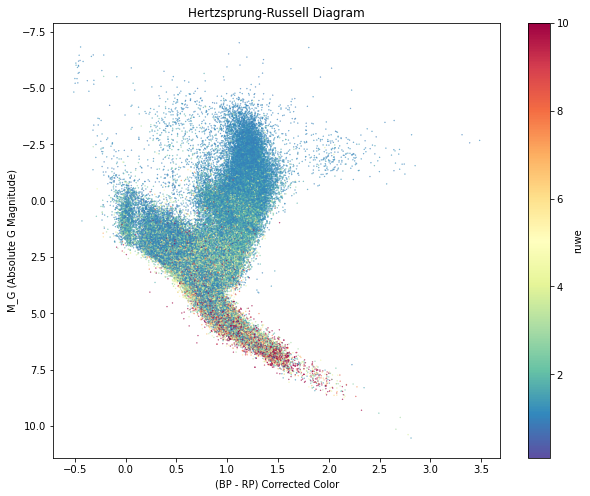

In [103]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Normalize ruwe values from 0.1 to 10
norm = Normalize(vmin=0.1, vmax=10)

# Plot the Hertzsprung-Russell diagram color coded by ruwe
plt.figure(figsize=(10, 8))
sc = plt.scatter(cross_df_filtered['bp_rp_corrected'], cross_df_filtered['M_G'], s=0.1, c=cross_df_filtered['ruwe'], cmap='Spectral_r', norm=norm, alpha=1)

# Invert y-axis to have bright stars at the top
plt.gca().invert_yaxis()

# Set plot labels and title
plt.xlabel('(BP - RP) Corrected Color')
plt.ylabel('M_G (Absolute G Magnitude)')
plt.title('Hertzsprung-Russell Diagram')

# Add color bar
plt.colorbar(sc, label='ruwe')

# Show the plot
plt.show()

### Compute Abs magnitude from apparent magnitude, take distance 1/parallax, absolute mag

### parameter space

In [104]:
# read the CSV file back into a DataFrame
sb = pd.read_csv('data/10k_SB.csv')

# Keep in the dataframe only Periods less than dr3Period = 2.8333333333333335 years
sb = sb[sb['P'] <= dr3Period]

# N = dr3Period / df['P'] create a new column 'N' in the DataFrame
sb['N_orb'] = sb['P'] / dr3Period

# print the column names
print(sb.columns)

Index(['RA', 'Dec', 'pmRA', 'pmDec', 'pllx', 'M_tot', 'q', 'l', 'a', 'e', 'P',
       'tPeri', 'vTheta', 'vPhi', 'vOmega', 'predict_dTheta', 'simple_dTheta',
       'N_obs', 'sigma_al', 'sigma_ac', 'fit_ra', 'fit_dec', 'fit_pmrac',
       'fit_pmdec', 'fit_pllx', 'sigma_rac', 'sigma_dec', 'sigma_pmrac',
       'sigma_pmdec', 'sigma_pllx', 'N_vis', 'frac_good', 'AEN', 'UWE',
       'N_orb'],
      dtype='object')


# Calculate Radial Velocity Error

#### Assume P<=B and zeta = zeta_0

In [105]:
# Sample zeta_0 and beta_0 from normal distributions with mean 0.5 and standard deviation 0.2
sb['zeta_0'] = np.random.normal(0.5, 0.2, len(sb))
sb['beta_0'] = np.random.normal(0.5, 0.2, len(sb))

In [106]:
# calculate sigma_spectroscopic_error for all the data points in the dataframe
sb['sigma_spectroscopic_error'] = sigma_spectroscopic_error(sb['q'], sb['a'], sb['P'], sb['zeta_0'])

# Calculate sigma_theta

#### Assume P<=B and beta = beta_0

In [107]:
# calculate sigma_astrometric_error for all the data points in the dataframe
sb['sigma_astrometric_error'] = sigma_astrometric_error(sb['q'], sb['l'], sb['pllx'], sb['a'], AU, sb['beta_0'])

# Calculate inferred P' and q' 

#### The inferred mass ratios and periods using Equations 8 and 11 are described below

In [108]:
sb["P'"] = inferred_P(AU, sb['sigma_spectroscopic_error'], sb['sigma_astrometric_error'], sb['pllx'], sb['zeta_0'], sb['beta_0'])
sb = sb[sb["P'"] < 3]

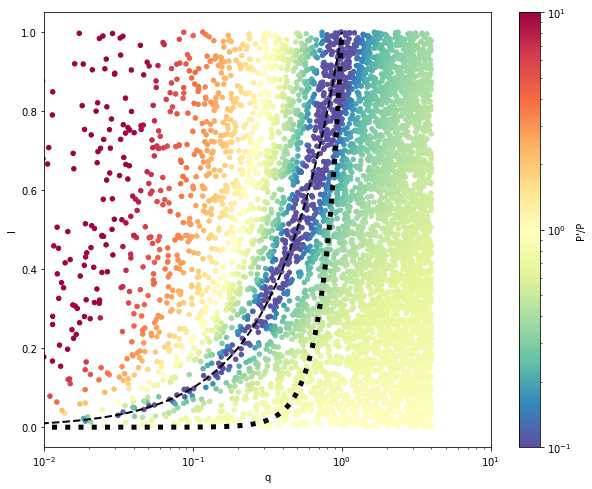

In [109]:
plot_scatter_with_lines(sb, 'q', 'l', "P'", "P", "P'/P")

In [110]:
sb["q'"] = solve_q(AU, G, M_sun, sb['sigma_spectroscopic_error'], sb['sigma_astrometric_error'], sb['pllx'], sb['zeta_0'], sb['beta_0'])

In [111]:
sb = sb[sb["q'"]<4]

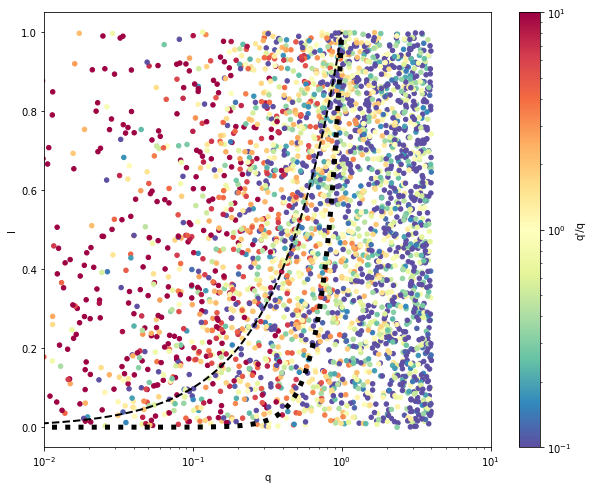

In [112]:
plot_scatter_with_lines(sb, 'q', 'l', "q'", "q", "q'/q")

#### Simulate Dark-Binaries

In [114]:
# read the CSV file back into a DataFrame
db = pd.read_csv('data/10k_DB.csv')

# Keep in the dataframe only Periods less than dr3Period = 2.8333333333333335 years
db = db[db['P'] <= dr3Period]

# N = dr3Period / df['P'] create a new column 'N' in the DataFrame
db['N_orb'] = db['P'] / dr3Period

# print the column names
print(db.columns)

Index(['RA', 'Dec', 'pmRA', 'pmDec', 'pllx', 'M_tot', 'q', 'l', 'a', 'e', 'P',
       'tPeri', 'vTheta', 'vPhi', 'vOmega', 'predict_dTheta', 'simple_dTheta',
       'N_obs', 'sigma_al', 'sigma_ac', 'fit_ra', 'fit_dec', 'fit_pmrac',
       'fit_pmdec', 'fit_pllx', 'sigma_rac', 'sigma_dec', 'sigma_pmrac',
       'sigma_pmdec', 'sigma_pllx', 'N_vis', 'frac_good', 'AEN', 'UWE',
       'N_orb'],
      dtype='object')


# Calculate Radial Velocity Error

#### Assume P<=B and zeta = zeta_0

In [115]:
# Sample zeta_0 and beta_0 from normal distributions with mean 0.5 and standard deviation 0.2
db['zeta_0'] = np.random.normal(0.5, 0.2, len(db))
db['beta_0'] = np.random.normal(0.5, 0.2, len(db))

In [116]:
db['sigma_spectroscopic_error'] = sigma_spectroscopic_error(db['q'], db['a'], db['P'], db['zeta_0'])

# Calculate sigma_theta

#### Assume P<=B and beta = beta_0

In [117]:
db['sigma_astrometric_error'] = sigma_astrometric_error(db['q'], db['l'], db['pllx'], db['a'], AU, db['beta_0'])

# Calculate inferred P' and q' 

#### The inferred mass ratios and periods using Equations 8 and 11 are described below

In [118]:
db["P'"] = inferred_P(AU, db['sigma_spectroscopic_error'], db['sigma_astrometric_error'], db['pllx'], db['zeta_0'], db['beta_0'])

In [119]:
db = db[db["P'"]<3]

In [120]:
db["q'"] = solve_q(AU, G, M_sun, db['sigma_spectroscopic_error'], db['sigma_astrometric_error'], db['pllx'], db['zeta_0'], db['beta_0'])


/Users/ynwa1995/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [121]:
db = db[db["q'"]<4]

# Plot parameter space

In [122]:
db['M_1'] = 1
sb['M_1'] = 1
db['M_2'] = db['q'] * db['M_1']
sb['M_2'] = sb['q'] * sb['M_1']

<ipython-input-122-dcac112d79ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sb['M_1'] = 1
<ipython-input-122-dcac112d79ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sb['M_2'] = sb['q'] * sb['M_1']


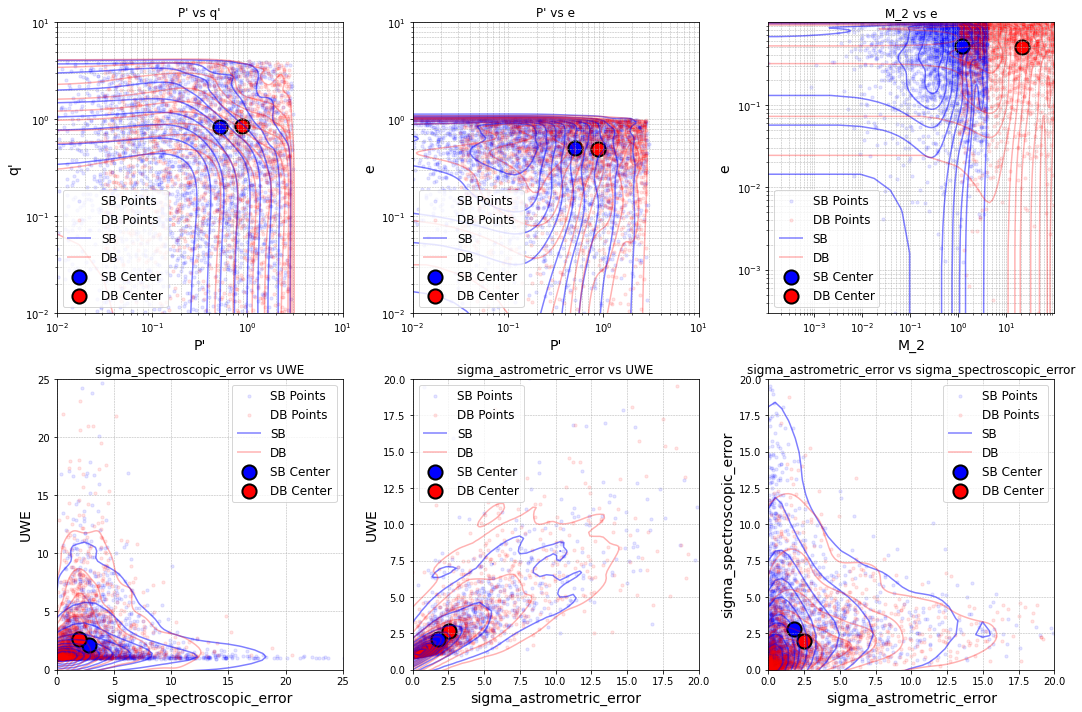

In [123]:
import matplotlib.pyplot as plt

# Assuming plot_single_cluster_with_center is already defined and modified to accept an axis parameter

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# List of parameters for each subplot
params = [
    ("P'", "q'", (10e-3, 10), (10e-3, 10), True, True),
    ("P'", "e", (10e-3, 10), (10e-3, 10),True, True),
    ("M_2", "e", None, None, True, True),
    ("sigma_spectroscopic_error", "UWE", (0, 25), (0, 25), False, False),
    ("sigma_astrometric_error", "UWE", (0, 20), (0, 20), False, False),
    ("sigma_astrometric_error", "sigma_spectroscopic_error", (0, 20), (0, 20), False, False)
]

# Plot each subplot
for ax, (x, y, x_lim, y_lim, log_x, log_y) in zip(axs, params):
    plot_single_cluster_with_center(sb, db, x, y, x_lim=x_lim, y_lim=y_lim, log_x=log_x, log_y=log_y, ax=ax)
    ax.set_title(f'{x} vs {y}')

# Adjust layout
plt.tight_layout()
plt.show()

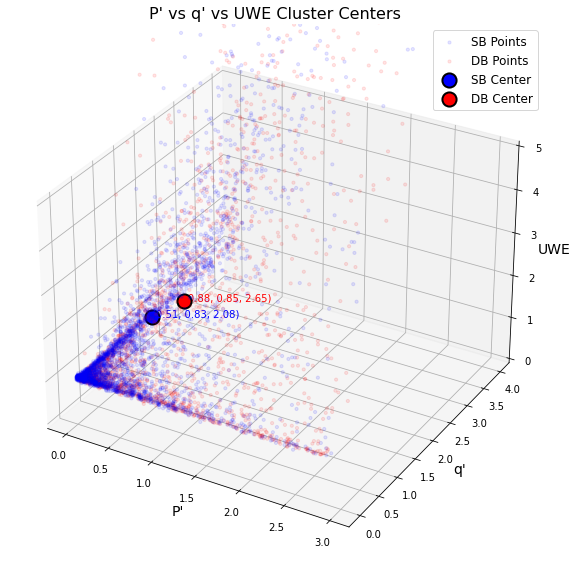

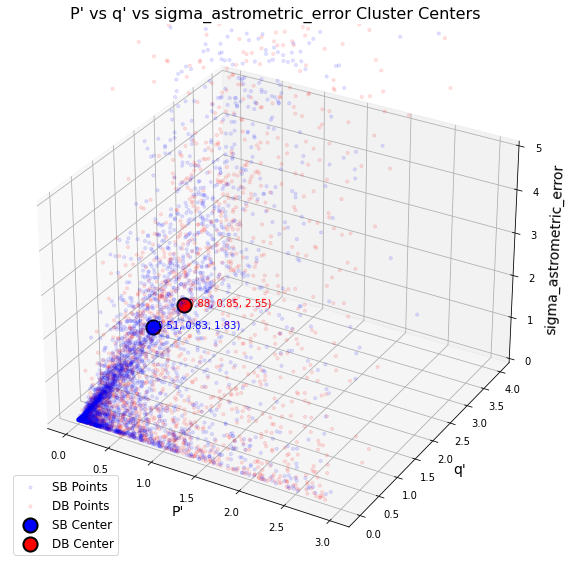

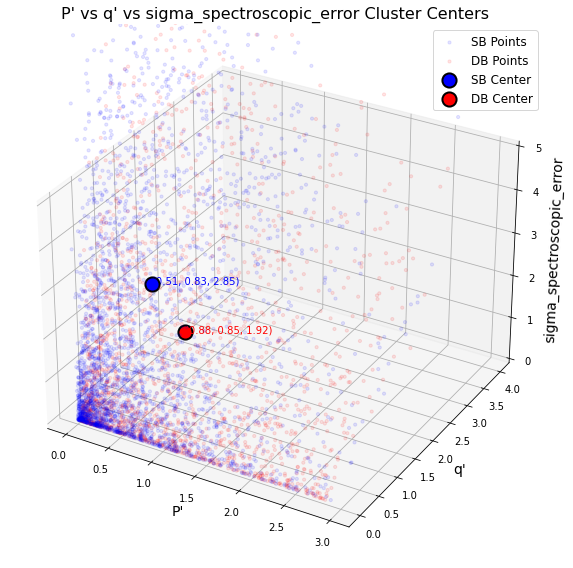

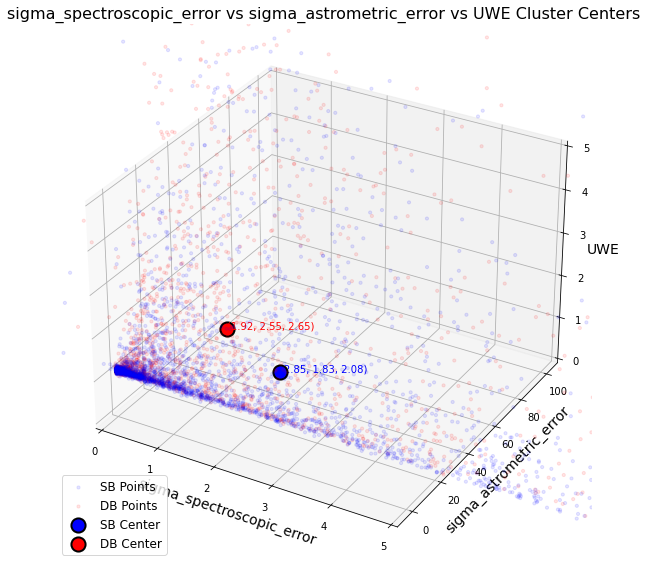

In [46]:
plot_3d_clusters(sb, db, "P'", "q'", "UWE", x_min=None, x_max=None, y_min=None, y_max=None, z_min=0, z_max=5)
plot_3d_clusters(sb, db, "P'", "q'", "sigma_astrometric_error", x_min=None, x_max=None, y_min=None, y_max=None, z_min=0, z_max=5)
plot_3d_clusters(sb, db, "P'", "q'", "sigma_spectroscopic_error", x_min=None, x_max=None, y_min=None, y_max=None, z_min=0, z_max=5)
plot_3d_clusters(sb, db, "sigma_spectroscopic_error", "sigma_astrometric_error", "UWE", x_min=0, x_max=5, y_min=None, y_max=None, z_min=0, z_max=5)

### Plot for 155 mass_ratios

In [148]:
df_cross = pd.read_csv('data/gaia_dr3_cross.csv')

In [149]:
# make a dataframe with df['mass_ratio'] not None
df_155 = df_cross[df_cross['mass_ratio'].notna()]

# keep only the rows with ruwe not none
df_155 = df_155[df_155['ruwe'].notna()]

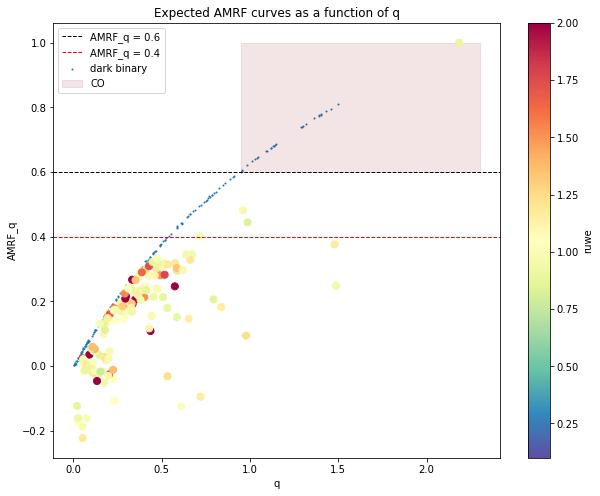

In [150]:
# db vs sb

# Calculate the AMRF for each row in the DataFrame
df_155['AMRF_q'] = AMRF_q(df_155['mass_ratio'], df_155['g_luminosity_ratio'])

# norm
norm = mpl.colors.Normalize(vmin=0.1, vmax=2)

# plot q on the x-axis and AMRF_q on the y-axis
# for each q value, plot only the maximum AMRF_q value so that I get a line
# fig size 10, 6
plt.figure(figsize=(10, 8))
# place a line at y = 0.6 and fill it with a dottet pattern
plt.axhline(y=0.6, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.4, color='red', linestyle='--', linewidth=1)
plt.scatter(df_dark_sim['q'], df_dark_sim['AMRF_q'], s=1)
# plot a dotted pattern in the quadrant from 0.6 to 1 in y axis and 1 to end in x axis
plt.fill_between([0.95, 2.3], 0.6, 1, color='darkred', alpha=0.1)
# color code of df_AMRF by ruwe
plt.scatter(df_155['mass_ratio'], df_155['AMRF_q'], c=df_155["ruwe"], cmap='Spectral_r', s=50, norm=norm)
# labels
plt.legend(['AMRF_q = 0.6', 'AMRF_q = 0.4', 'dark binary', 'CO'])
# plot title
plt.title('Expected AMRF curves as a function of q')
# color map
plt.colorbar(label='ruwe')
plt.xlabel('q')
plt.ylabel('AMRF_q')
plt.show()

## Missing Data Inference with ML

Training model:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting test set:   0%|          | 0/1 [00:00<?, ?it/s]

Mean Squared Error: 0.029063530127876762
Mean Absolute Error: 0.1345808376316671
R² Score: -0.2669482016536875
Root Mean Squared Error: 0.17048029249117552
                   Feature  Importance
17      g_luminosity_ratio    0.270379
3          phot_g_mean_mag    0.220012
19  semi_amplitude_primary    0.211230
11          rv_nb_transits    0.051409
4                    bp_rp    0.041103
5                 parallax    0.037887
18                  period    0.031415
9    radial_velocity_error    0.029505
15         radial_velocity    0.023339
8                     ruwe    0.018002
7                    pmdec    0.017042
16          parallax_error    0.011719
2                      dec    0.009876
12              ag_gspphot    0.009791
0                SOURCE_ID    0.007230
6                     pmra    0.003613
1                       ra    0.002715
14         non_single_star    0.002437
13        ebpminrp_gspphot    0.001294
10          rv_method_used    0.000000


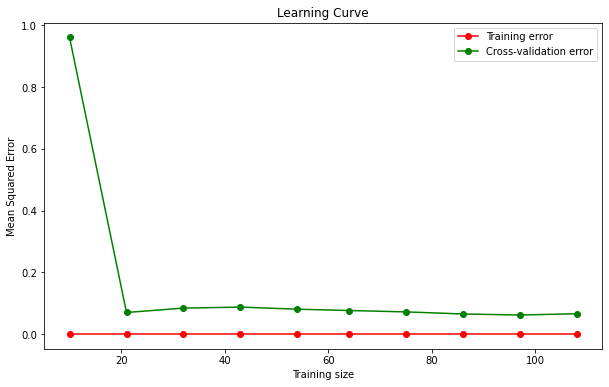

Predicting missing values:   0%|          | 0/1 [00:00<?, ?it/s]

In [151]:
nss_two_body_orbit_inference = fill_missing_values_XGBOOST(df_cross, 'mass_ratio')

Training model:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting test set:   0%|          | 0/1 [00:00<?, ?it/s]

Mean Squared Error: 0.01590573070483114
Mean Absolute Error: 0.09731514608614561
R² Score: 0.7521693517719846
Root Mean Squared Error: 0.12611792380479128
                   Feature  Importance
17              mass_ratio    0.669621
14         non_single_star    0.059355
19  semi_amplitude_primary    0.033584
18                  period    0.028055
11          rv_nb_transits    0.027573
12              ag_gspphot    0.021859
4                    bp_rp    0.016964
3          phot_g_mean_mag    0.014984
15         radial_velocity    0.014280
6                     pmra    0.014139
13        ebpminrp_gspphot    0.013677
9    radial_velocity_error    0.013667
5                 parallax    0.013211
8                     ruwe    0.011485
2                      dec    0.011424
1                       ra    0.010557
16          parallax_error    0.010086
7                    pmdec    0.008994
0                SOURCE_ID    0.006485
10          rv_method_used    0.000000


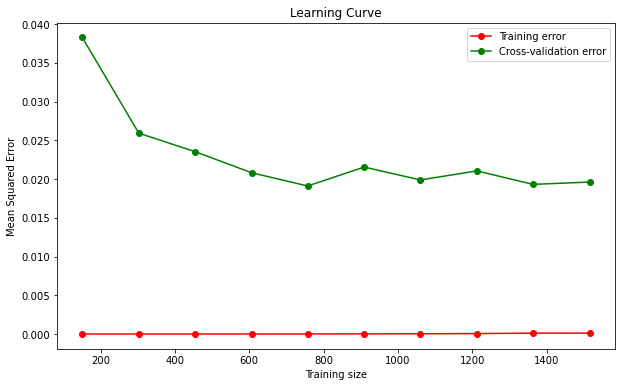

Predicting missing values:   0%|          | 0/1 [00:00<?, ?it/s]

In [152]:
nss_two_body_orbit_inference = fill_missing_values_XGBOOST(df_cross, 'g_luminosity_ratio')

Training error measures performance on the training set.

Cross-validation error helps estimate how well the model will generalize to new data, balancing the risk of overfitting.

In [153]:
# # add period to the dataframe
# nss_gaia_inference = pd.merge(df_cross, gaia, on='SOURCE_ID', how='inner')

# df_inference = nss_gaia_inference

In [154]:
df_inference = df_cross

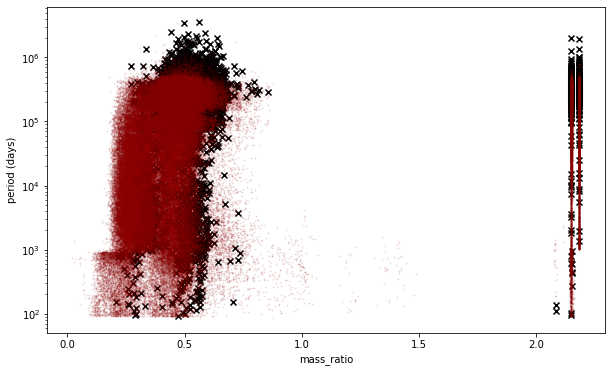

In [155]:
# filter the dataframe to keep only ruwe > 4
df_high_ruwe = df_inference[df_inference['ruwe'] >= 10]
df_low_ruwe = df_inference[df_inference['ruwe'] < 10]

# plot p vs q color coded by ruwe for df_high_ruwe in crosses and df_low_ruwe in circles
plt.figure(figsize=(10, 6))
plt.scatter(df_high_ruwe['mass_ratio'], df_high_ruwe['period']*365, c='black', marker='x', label='ruwe >= 7')
plt.scatter(df_low_ruwe['mass_ratio'], df_low_ruwe['period']*365, c='darkred', marker='o', s=1, alpha=0.1 ,label='ruwe < 7')
plt.xlabel('mass_ratio')
plt.ylabel('period (days)')
plt.yscale('log')
plt.show()

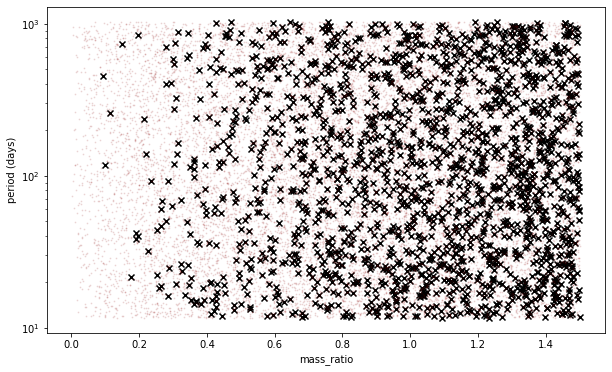

In [156]:
# filter the dataframe to keep only ruwe > 4
df_high_ruwe_sim = df_sim[df_sim['UWE'] >= 10]
df_low_ruwe_sim = df_sim[df_sim['UWE'] < 10]

# plot p vs q color coded by ruwe for df_high_ruwe in crosses and df_low_ruwe in circles
plt.figure(figsize=(10, 6))
plt.scatter(df_high_ruwe_sim['q'], df_high_ruwe_sim['P']*365, c='black', marker='x', label='ruwe >= 7')
plt.scatter(df_low_ruwe_sim['q'], df_low_ruwe_sim['P']*365, c='darkred', marker='o', s=1, alpha=0.1 ,label='ruwe < 7')
plt.xlabel('mass_ratio')
plt.ylabel('period (days)')
plt.yscale('log')
plt.show()

### Triage

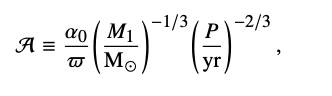

In [157]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/AMRF.png'
display(Image(filename=img_path, width=300, height=200))  # Adjust width and height as needed


In [158]:
# Calculate the AMRF for each row in the DataFrame
df_sim['AMRF'] = AMRF(df_sim['a'], M_sun, df_sim['pllx'], df_sim['P'])

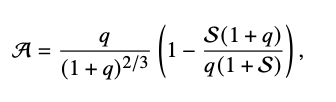

In [159]:
from IPython.display import Image, display

# Display an image from a local file with specified size
img_path = 'images/AMRF_q.png'
display(Image(filename=img_path, width=300, height=200))  # Adjust width and height as needed


In [160]:
df_sim['AMRF_q'] = AMRF_q(df_sim['q'], df_sim['l'])

In [161]:
# # remove rows with negative AMRF_q values and less than 1
df_sim = df_sim[df_sim['AMRF_q'] >= 0]
df_sim = df_sim[df_sim['AMRF_q'] <= 1]
df_sim = df_sim[df_sim['q'] <= 1.5]
df_dark_sim = df_sim[df_sim['l']<=0.005]

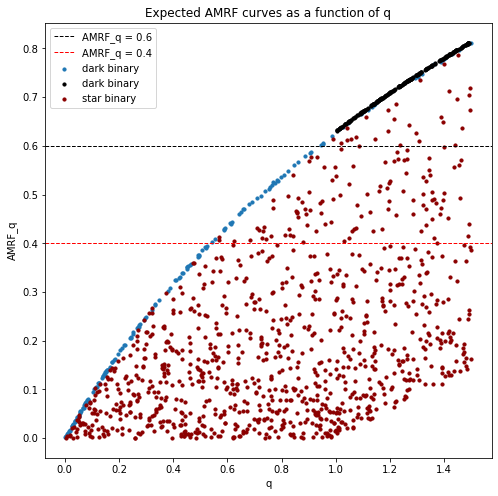

In [162]:
# db vs sb

# Calculate the AMRF for each row in the DataFrame
db['AMRF'] = AMRF(db['a'], M_sun, db['pllx'], db['P'])

db['AMRF_q'] = AMRF_q(db['q'], db['l'])

# # remove rows with negative AMRF_q values and less than 1
db_AMRF = db[db['AMRF_q'] >= 0]
db_AMRF = db_AMRF[db_AMRF['AMRF_q'] <= 1]
db_AMRF = db_AMRF[db_AMRF['q'] <= 1.5]

# Calculate the AMRF for each row in the DataFrame
sb['AMRF'] = AMRF(sb['a'], M_sun, sb['pllx'], sb['P'])

sb['AMRF_q'] = AMRF_q(sb['q'], sb['l'])

# # remove rows with negative AMRF_q values and less than 1
sb_AMRF = sb[sb['AMRF_q'] >= 0]
sb_AMRF = sb_AMRF[sb_AMRF['AMRF_q'] <= 1]
sb_AMRF = sb_AMRF[sb_AMRF['q'] <= 1.5]

# plot q on the x-axis and AMRF_q on the y-axis
# for each q value, plot only the maximum AMRF_q value so that I get a line
# fig size 10, 6
plt.figure(figsize=(8, 8))
# place a line at y = 0.6 and fill it with a dottet pattern
plt.axhline(y=0.6, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.4, color='red', linestyle='--', linewidth=1)
plt.scatter(df_dark_sim['q'], df_dark_sim['AMRF_q'], s=10)
plt.scatter(db_AMRF['q'], db_AMRF['AMRF_q'], color='black', s=10)
plt.scatter(sb_AMRF['q'], sb_AMRF['AMRF_q'], color='darkred', s=10)
# labels
plt.legend(['AMRF_q = 0.6', 'AMRF_q = 0.4', 'dark binary', 'dark binary', 'star binary'])
# plot title
plt.title('Expected AMRF curves as a function of q')
plt.xlabel('q')
plt.ylabel('AMRF_q')
plt.show()

In [163]:
df_inference.columns

Index(['SOURCE_ID', 'ra', 'dec', 'phot_g_mean_mag', 'bp_rp', 'parallax',
       'pmra', 'pmdec', 'ruwe', 'radial_velocity_error', 'rv_method_used',
       'rv_nb_transits', 'ag_gspphot', 'ebpminrp_gspphot', 'non_single_star',
       'radial_velocity', 'parallax_error', 'mass_ratio', 'g_luminosity_ratio',
       'period', 'semi_amplitude_primary'],
      dtype='object')

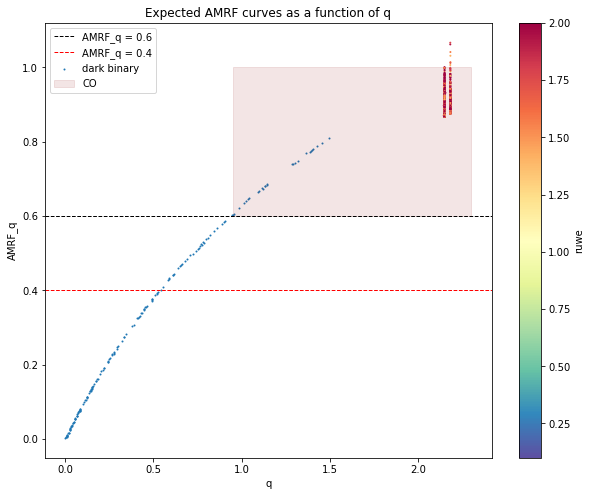

In [164]:
# db vs sb

# Calculate the AMRF for each row in the DataFrame
df_inference['AMRF'] = AMRF(df_inference['semi_amplitude_primary'], M_sun, df_inference['parallax'], df_inference['period'])

df_inference['AMRF_q'] = AMRF_q(df_inference['mass_ratio'], df_inference['g_luminosity_ratio'])

# # # remove rows with negative AMRF_q values and less than 1
# df_AMRF = df_inference[df_inference['AMRF_q'] >= 0]
# df_AMRF = df_AMRF[df_AMRF['AMRF_q'] <= 1]

# keep only df_AMRF["ruwe"]>5
df_AMRF = df_inference[df_inference['mass_ratio'] >= 1]
df_AMRF = df_AMRF[df_AMRF["ruwe"]>1.4]
df_AMRF = df_AMRF[df_AMRF["g_luminosity_ratio"]<0.1]

# norm
norm = mpl.colors.Normalize(vmin=0.1, vmax=2)

# plot q on the x-axis and AMRF_q on the y-axis
# for each q value, plot only the maximum AMRF_q value so that I get a line
# fig size 10, 6
plt.figure(figsize=(10, 8))
# place a line at y = 0.6 and fill it with a dottet pattern
plt.axhline(y=0.6, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0.4, color='red', linestyle='--', linewidth=1)
plt.scatter(df_dark_sim['q'], df_dark_sim['AMRF_q'], s=1)
# plot a dotted pattern in the quadrant from 0.6 to 1 in y axis and 1 to end in x axis
plt.fill_between([0.95, 2.3], 0.6, 1, color='darkred', alpha=0.1)
# color code of df_AMRF by ruwe
plt.scatter(df_AMRF['mass_ratio'], df_AMRF['AMRF_q'], c=df_AMRF["ruwe"], cmap='Spectral_r', s=1, norm=norm)
# labels
plt.legend(['AMRF_q = 0.6', 'AMRF_q = 0.4', 'dark binary', 'CO'])
# plot title
plt.title('Expected AMRF curves as a function of q')
# color map
plt.colorbar(label='ruwe')
plt.xlabel('q')
plt.ylabel('AMRF_q')
plt.show()

Wait for Andrews reply find MLR to simulate MS MS binary

Plot q vs AMRF for 155 q data

In [113]:
df_AMRF


dec_x       period  arg_periastron            SOURCE_ID    pmdec_x  \
975          NaN    23.110304      288.409793   116911213118745856        NaN   
1161   33.504085   539.428858             NaN   136713967288882816 -48.488635   
1584   30.818642   677.765056             NaN   156986384725473152 -64.807103   
2032   32.784134   412.950442             NaN   172072062216272512 -28.262945   
2439         NaN    22.508234      204.879298   186064584630433408        NaN   
...          ...          ...             ...                  ...        ...   
43967  87.560362   228.947822             NaN  1728141389319482112 -10.192791   
44171   5.017420   654.139926             NaN  1735268423691343488  -1.791876   
44462        NaN    32.305524      195.243976  1744073763778472960        NaN   
44488  10.586878   240.430074             NaN  1744879735864839424 -25.269856   
44709   8.153783  1031.006235             NaN  1750001196604047616 -29.784420   

       center_of_mass_velocity nss_solution_type  t_periastron  mass_ratio  \
975                 -18.025815               SB1     -8.281528    2.094352   
1161                -12.896801   AstroSpectroSB1      4.114280    2.127014   
1584                 12.977085   AstroSpectroSB1    -21.274641    2.071164   
2032                 76.106716   AstroSpectroSB1   -134.022618    2.066966   
2439                -22.202901               SB1     -0.184234    2.090255   
...                        ...               ...           ...         ...   
43967               -14.148381   AstroSpectroSB1      5.146101    2.138068   
44171                -2.449511   AstroSpectroSB1     27.965449    2.138988   
44462                33.172224               SB1      6.323625    2.132467   
44488               -14.830478   AstroSpectroSB1     39.696338    2.136348   
44709               -10.566537   AstroSpectroSB1      3.052493    2.126869   

       g_luminosity_ratio  ...    pmdec_y       ruwe  radial_velocity_error  \
975              0.065322  ...  -2.328655   5.520422               8.034734   
1161             0.098950  ... -48.257798   6.354181               2.145933   
1584             0.094338  ... -62.583934  23.043413               1.672997   
2032             0.094338  ... -28.307955  12.120296               3.006818   
2439             0.094295  ...  -5.786330   8.422418               6.109738   
...                   ...  ...        ...        ...                    ...   
43967            0.042121  ... -10.171953   1.712957               2.347441   
44171            0.088015  ...  -1.859940   1.995284               0.832044   
44462            0.067731  ...  -1.672913   2.145442               4.639189   
44488            0.094451  ... -25.226594   2.606243               1.532815   
44709            0.066499  ... -30.957128   4.197347               1.518462   

       rv_method_used  rv_nb_transits  non_single_star  radial_velocity  \
975                 1              13                2       -20.601458   
1161                1              12                3       -12.609443   
1584                1              27                3        16.804829   
2032                1              13                3        78.685844   
2439                1              27                2       -13.404466   
...               ...             ...              ...              ...   
43967               1              18                3       -12.723913   
44171               1              24                3        -3.020096   
44462               1              27                2        34.188229   
44488               1              29                3       -10.101321   
44709               1              28                3       -10.857243   

       parallax_error      AMRF    AMRF_q  
975          0.073003  1.265864  0.896935  
1161         0.090605       NaN  0.863013  
1584         0.340942       NaN  0.854965  
2032         0.315902       NaN  0.853928  
2439         0.124981  1.755249